In [11]:
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
%matplotlib inline

################################################################################
# Some simple plotting utilities
################################################################################


def plot_data(data: np.ndarray,
              labels: np.ndarray,
              ax: matplotlib.axes.Axes = None):
    """
    A helper function to plot our data sets

    PARAMETERS
    ----------
    data      A numpy array of 2 columns (dimensions) and 2*examples_per_class rows

    labels    A numpy vector with 2*examples_per_class, with a +1 or -1 in each
              element. The jth element is the label of the jth example

    ax        An optional matplotlib axis object to plot to
    """

    # require shape (n, 2)
    assert data.ndim == 2
    assert data.shape[-1] == 2

    if type(data) == torch.Tensor:
        data = data.numpy()

    # plot the data
    pos_idx = np.where(labels == 1)
    neg_idx = np.where(labels == -1)

    if ax is None:
        ax = plt
    ax.plot(
        data.T[0, pos_idx],
        data.T[1, pos_idx],
        'r^',
        label='positive'
    )
    ax.plot(
        data.T[0, neg_idx],
        data.T[1, neg_idx],
        'bo',
        label='negative'
    )
    ax.axis('equal')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="upper right")

    if ax is None:
        plt.show()


def plot_decision_surface(model=None,
                          axis_limits=(-5, 5, -5, 5),
                          ax: matplotlib.axes.Axes = None
                          ):
    """
    Creates a grid of points, measures what a model would label each
    point as, and uses this data to draw a region for class +1 and a region for
    class -1.

    PARAMETERS
    ----------
    model       A callable model that can take 2-d real-valued input and produce
                a +1 or -1 label for each data point.

    axis_limits An array-like object with 4 floats [lowest_horizontal, highest_horizontal,
                lowest_vertical, highest_vertical]. This sets the limits over which
                the decision surface will be caluclated and plotted.

    ax          An optional matplotlib axis object to plot to

    RETURNS
    -------
    my_contour  a matplotlib.contour.QuadContourSet with the contour
    """

    # Create a grid of points spanning the entire space displayed in the axis.
    # This will let us draw the decision boundary later
    xx, yy = np.meshgrid(np.arange(axis_limits[0], axis_limits[1], .05),
                         np.arange(axis_limits[2], axis_limits[3], .05))
    data = np.concatenate([xx.reshape([1, -1]), yy.reshape([1, -1])]).T

    # Predict the class of each point in XGrid, using the classifier.
    # This shows our regions determined by the classifier
    if isinstance(model, nn.Module):
        with torch.no_grad():
            pl = model(torch.tensor(data).to(dtype=torch.float32))
            predicted_labels = np.sign(pl.numpy())
    else:
        predicted_labels = model(data)

    predicted_labels = predicted_labels.reshape(xx.shape)

    # Put the result into a color plot
    if ax is None:
        ax = plt

    ax.contourf(xx, yy, predicted_labels, cmap=plt.cm.Paired)
    ax.axis('equal')
    ax.axis('tight')

    if ax is None:
        plt.show()


def compute_bounds(features):
    min1, max1 = features[:, 0].min()-1, features[:, 0].max()+1
    min2, max2 = features[:, 1].min()-1, features[:, 1].max()+1
    return (min1, max1, min2, max2)


def plot_decision_regions(
        features, targets, model,
        axis=None, transform=None,
        bounds=None,
        title='Decision Surface'):
    """
    Slightly different plotting approach than above. Used in backprop demo.

    This function produces a single plot containing a scatter plot of the
    features, targets, and decision region of the model.

    Args:
        features (np.ndarray): 2D array containing real-valued inputs.
        targets (np.ndarray): 1D array containing binary targets.
        model: a learner with .predict() method
        axis: the axis on which to plot. If None, create a new plot
        title: title of the plot
    Returns:
        None (plots to the active figure)
    """

    # define bounds of the domain
    if bounds is None:
        min1, max1, min2, max2 = compute_bounds(features)
    else:
        min1, max1, min2, max2 = bounds

    # define grid for visualizing decision regions
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)

    xx, yy = np.meshgrid(x1grid, x2grid)

    # flatten grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # horizontally stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))

    # if we're transforming the features, do that now
    #     this allows xx and yy to still be in 2D for the visualization
    #     but grid has been transformed so it matches up with the fit model
    if transform is not None:
        grid = transform(grid)

    # generate predictions over grid
    yhat = model.predict(grid)

    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)


    if axis is None:
        fig, axis = plt.subplots()

    # plot the grid of x, y and z values as a surface
    binary_cmap = matplotlib.colors.ListedColormap(['#9ce8ff', '#ffc773'])
    axis.contourf(xx, yy, zz, cmap=binary_cmap, alpha=0.7)

    # plot "negative" class:
    row_idx_neg = np.where(targets < 0.5)[0]
    axis.scatter(
        features[row_idx_neg, 0], features[row_idx_neg, 1],
        label='negative')

    # plot "positive" class:
    row_idx_pos = np.where(targets > 0.5)[0]
    axis.scatter(
        features[row_idx_pos, 0], features[row_idx_pos, 1],
        label='positive')

    axis.set_title(title)
    axis.set_xlim(min1, max1)
    axis.set_ylim(min2, max2)

    axis.legend(loc="upper left")

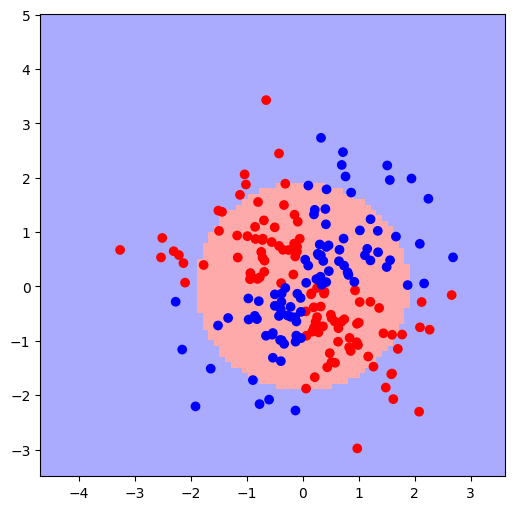

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import sys
import os
import random

%matplotlib inline

np.random.seed(42)
torch.manual_seed(0)

def read_data(name,mode):

    x_data = []
    y_data = []
    label_data = []

    base_dir = os.getcwd()
    root = base_dir
    filename = '%s/%s_%s.csv' % (root,name,mode)

    i = 0
    with open(filename,'rt') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(',')
            if i > 0:
                y = int(float(tokens[0]))
                x1 = float(tokens[1])
                x2 = float(tokens[2])
                x_data.append([1.0,x1,x2])
                y_data.append([y])
                temp = [0,0]
                temp[y] = 1
                label_data.append(temp)
            i = i + 1
    xs = np.array(x_data,dtype='float32')
    ys = np.array(y_data,dtype='float32')
    labels = np.array(label_data,dtype='float32')
    return(xs,ys,labels)

class net3(nn.Module):
    def __init__(self,input_size,nodes,output_size):
        super(net3,self).__init__()
#        self.l1 = nn.Linear(input_size,nodes)
#        self.activation = nn.Tanh()

    def forward(self,x):
#        output = self.l1(x)
#        output = self.activation(output)
        a = torch.mul(x[:,1],x[:,1])
        b = torch.mul(x[:,2],x[:,2])
        c = (a+b)/9.0
        output = torch.exp(c)
        return output

def draw_example(nodes,name,model):
    x_train, y_train, label_train = read_data(name,'train')
    x_test, y_test, label_test = read_data(name,'test')

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6*(1+0)))

    h = .1  # step size in the mesh
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
    y_min, y_max = x_train[:, 2].min() - 1, x_train[:, 2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    Z = np.zeros([xx.shape[0],yy.shape[1]],dtype='float32')
    Z2 = np.zeros([nodes,xx.shape[0],yy.shape[1]],dtype='float32')
    grid_data = np.ones([1,3],dtype='float32')

    grid_data2 = np.zeros([1,3],dtype='float32')
    for i in range(xx.shape[0]):
        for j in range(yy.shape[1]):
            x = xx[i,j]
            y = yy[i,j]
            grid_data2[0,0] = 1.0
            grid_data2[0,1] = x
            grid_data2[0,2] = y

            x = torch.from_numpy(grid_data2)
            pred = model(x)
            if (pred[0].item()-6.0) > -4.5:
                yh = 1.0
            else:
                yh = 0.0
            Z[i,j] = yh
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
    ax.scatter(x_test[:, 1], x_test[:, 2], c=y_test[:,0], cmap=cmap_bold)

nodes = 3
name = 'xor'
model = net3(3,nodes,1)
draw_example(nodes,name,model=model)



In [13]:
#  Define the FFNN model
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x  # Raw logits for CrossEntropyLoss



In [14]:
# Define the training function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=1000):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels.squeeze())
                val_running_loss += loss.item() * inputs.size(0)
            val_loss = val_running_loss / len(val_loader.dataset)
            val_losses.append(val_loss)
        
        # Optionally print progress
        if (epoch+1) % 100 == 0 or epoch == 1:
            print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')
        
    return train_losses, val_losses



Processing dataset: xor

Training with hidden layer size k=2
Epoch [2/1000], Training Loss: 0.7083, Validation Loss: 0.6793
Epoch [100/1000], Training Loss: 0.6158, Validation Loss: 0.6683
Epoch [200/1000], Training Loss: 0.5519, Validation Loss: 0.6005
Epoch [300/1000], Training Loss: 0.5201, Validation Loss: 0.5653
Epoch [400/1000], Training Loss: 0.5096, Validation Loss: 0.5562
Epoch [500/1000], Training Loss: 0.5064, Validation Loss: 0.5522
Epoch [600/1000], Training Loss: 0.5053, Validation Loss: 0.5538
Epoch [700/1000], Training Loss: 0.5050, Validation Loss: 0.5536
Epoch [800/1000], Training Loss: 0.5046, Validation Loss: 0.5559
Epoch [900/1000], Training Loss: 0.5046, Validation Loss: 0.5572
Epoch [1000/1000], Training Loss: 0.5048, Validation Loss: 0.5582
Validation Accuracy for k=2: 0.7100

Training with hidden layer size k=3
Epoch [2/1000], Training Loss: 0.6880, Validation Loss: 0.7003
Epoch [100/1000], Training Loss: 0.6783, Validation Loss: 0.7130
Epoch [200/1000], Train

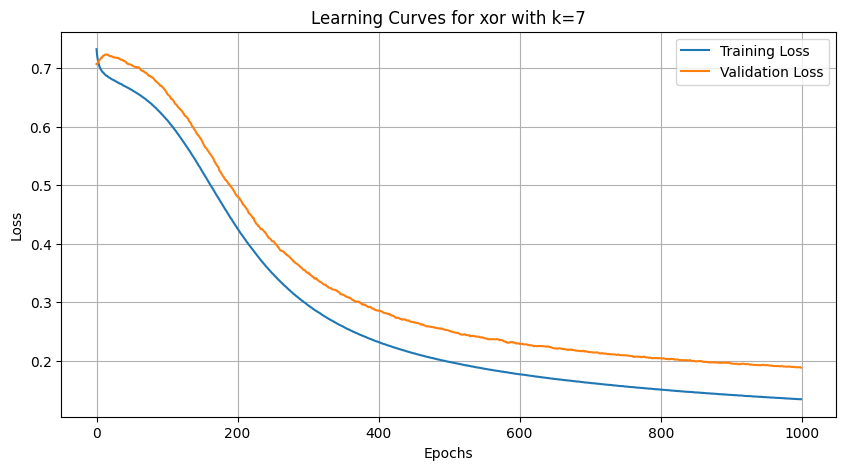

RuntimeError: mat1 and mat2 shapes cannot be multiplied (6360x2 and 3x7)

<Figure size 800x600 with 0 Axes>

In [28]:
# Main execution loop
datasets = ['xor']  # You can include other datasets like 'center_surround', 'two_gaussians', 'spiral'

for dataset_name in datasets:
    print(f"\nProcessing dataset: {dataset_name}")
    
    # Read the datasets
    X_train, y_train, labels_train = read_data(dataset_name, 'train')
    X_test, y_test, labels_test = read_data(dataset_name, 'test')
    X_valid, y_valid, labels_valid = read_data(dataset_name, 'valid')
    
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.from_numpy(X_train).float()
    y_train_tensor = torch.from_numpy(y_train).long().squeeze()
    X_val_tensor = torch.from_numpy(X_valid).float()
    y_val_tensor = torch.from_numpy(y_valid).long().squeeze()
    X_test_tensor = torch.from_numpy(X_test).float()
    y_test_tensor = torch.from_numpy(y_test).long().squeeze()
    
    # Create DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the range of hidden layer sizes to experiment with
    k_values = [2, 3, 5, 7, 9]
    
    # Initialize variables to keep track of the best model
    best_val_loss = float('inf')
    best_k = None
    best_model = None
    
    # Dictionaries to store training and validation losses for each k
    train_losses_dict = {}
    val_losses_dict = {}
    val_accuracies_dict = {}
    
    # Iterate over different hidden layer sizes
    for k in k_values:
        print(f"\nTraining with hidden layer size k={k}")
        
        # Initialize the model
        model = FFNN(input_size=X_train_tensor.shape[1], hidden_size=k, output_size=2)
        
        # Define the loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01)
        
        # Number of epochs
        num_epochs = 1000
        
        # Train the model
        train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)
        
        # Store the losses
        train_losses_dict[k] = train_losses
        val_losses_dict[k] = val_losses
        
        # After training, evaluate validation accuracy
        # (This has already been done inside train_model and printed)
        # To store it, you need to capture it during training
        # For simplicity, we'll compute it again here
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels.squeeze()).sum().item()
        val_accuracy = correct / total
        val_accuracies_dict[k] = val_accuracy
        print(f"Validation Accuracy for k={k}: {val_accuracy:.4f}")
        
        # Check if this model is the best so far
        val_loss = val_losses[-1]
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_k = k
            best_model = model

    # After evaluating all k's, print a summary table
    print(f"\nSummary of Results for dataset: {dataset_name}")
    print(f"{'k':<5}{'Val Loss':<15}{'Val Accuracy':<15}")
    for k in k_values:
        print(f"{k:<5}{val_losses_dict[k][-1]:<15.4f}{val_accuracies_dict[k]:<15.4f}")
    
    print(f"\nBest k for {dataset_name}: {best_k} with Validation Loss: {best_val_loss:.4f} and Validation Accuracy: {val_accuracies_dict[best_k]:.4f}")
    
    # Evaluate the best model on the test set
    best_model.eval()
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels.squeeze()).sum().item()
    test_accuracy = correct / total
    print(f"Test Accuracy for {dataset_name} with k={best_k}: {test_accuracy:.2f}")
    
    # (a) List hyperparameters
    print(f"\nHyperparameters for {dataset_name}:")
    print(f"Learning Rate: 0.01")
    print(f"Number of Epochs: {num_epochs}")
    print(f"Batch Size: {batch_size}")
    print(f"Hidden Layer Size (k): {best_k}")
    print(f"Activation Function: Tanh")
    print(f"Optimizer: SGD")
    
    # (b) Plot learning curves
    plt.figure(figsize=(10,5))
    plt.plot(train_losses_dict[best_k], label='Training Loss')
    plt.plot(val_losses_dict[best_k], label='Validation Loss')
    plt.title(f"Learning Curves for {dataset_name} with k={best_k}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # (d) Plot decision boundary using provided plotting functions
    # Map labels for plotting (from class indices to -1/+1)
    y_test_np = y_test_tensor.numpy()
    X_test_np = X_test_tensor.numpy()
    labels_test_mapped = np.where(y_test_np == 0, -1, 1)
    
    def model_for_plotting(input_data):
        with torch.no_grad():
            inputs = torch.from_numpy(input_data).float()
            outputs = best_model(inputs)
            _, predicted = torch.max(outputs, 1)
            predicted_labels = np.where(predicted.numpy() == 0, -1, 1)
            return predicted_labels
    
    # Compute axis limits based on test data
    axis_limits = [X_test_np[:, 0].min() - 1, X_test_np[:, 0].max() + 1,
                   X_test_np[:, 1].min() - 1, X_test_np[:, 1].max() + 1]
    
    # Plot the decision surface
    plt.figure(figsize=(8, 6))
    plot_decision_surface(model=model_for_plotting, axis_limits=axis_limits)
    
    # Overlay the test data
    plot_data(X_test_np, labels_test_mapped)
    
    plt.title(f"Decision Surface for {dataset_name} with k={best_k}")
    plt.show()

In [72]:
import numpy as np

def initialize_parameters(input_size, hidden_size, output_size):
    np.random.seed(42)  # For reproducibility
    W1 = np.random.randn(hidden_size, input_size) * 0.01  # Weights for input to hidden layer
    b1 = np.zeros((hidden_size, 1))                       # Biases for hidden layer
    W2 = np.random.randn(output_size, hidden_size) * 0.01 # Weights for hidden to output layer
    b2 = np.zeros((output_size, 1))                       # Biases for output layer
    return W1, b1, W2, b2

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(a):
    return a * (1 - a)


def forward_pass(X, W1, b1, W2, b2):
    Z1 = np.dot(W1, X) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    cache = (Z1, A1, Z2, A2)
    return A2, cache

def compute_loss(Y, A2):
    m = Y.shape[1]
    # To avoid log(0), add a small epsilon
    epsilon = 1e-15
    loss = - (1/m) * np.sum(Y * np.log(A2 + epsilon) + (1 - Y) * np.log(1 - A2 + epsilon))
    return loss

def backward_pass(X, Y, cache, W2):
    Z1, A1, Z2, A2 = cache
    m = X.shape[1]
    
    dZ2 = A2 - Y                          # (1, m)
    dW2 = (1/m) * np.dot(dZ2, A1.T)       # (1, hidden_size)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)  # (1,1)
    
    dA1 = np.dot(W2.T, dZ2)               # (hidden_size, m)
    dZ1 = dA1 * sigmoid_derivative(A1)       # (hidden_size, m)
    dW1 = (1/m) * np.dot(dZ1, X.T)        # (hidden_size, input_size)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)  # (hidden_size,1)
    
    gradients = {"dW1": dW1, "db1": db1,
                 "dW2": dW2, "db2": db2}
    return gradients

def train_nn(X_train, Y_train, X_val, Y_val, hidden_size=3, learning_rate=0.1, num_epochs=1000):
    input_size = X_train.shape[0]
    output_size = Y_train.shape[0]
    
    # Initialize parameters
    W1, b1, W2, b2 = initialize_parameters(input_size, hidden_size, output_size)
    
    # Training loop
    for epoch in range(1, num_epochs + 1):
        # Forward pass
        A2, cache = forward_pass(X_train, W1, b1, W2, b2)
        
        # Compute loss
        loss = compute_loss(Y_train, A2)
        
        # Backward pass
        gradients = backward_pass(X_train, Y_train, cache, W2)
        
        # Update parameters
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, gradients, learning_rate)
        
        # Validation loss
        A2_val, _ = forward_pass(X_val, W1, b1, W2, b2)
        val_loss = compute_loss(Y_val, A2_val)
        
        # Print progress
        if epoch % 100 == 0 or epoch == 1:
            print(f"Epoch {epoch}: Training Loss = {loss:.4f}, Validation Loss = {val_loss:.4f}")
    
    parameters = {"W1": W1, "b1": b1,
                  "W2": W2, "b2": b2}
    return parameters

def update_parameters(W1, b1, W2, b2, gradients, learning_rate):
    W1 -= learning_rate * gradients["dW1"]
    b1 -= learning_rate * gradients["db1"]
    W2 -= learning_rate * gradients["dW2"]
    b2 -= learning_rate * gradients["db2"]
    return W1, b1, W2, b2


def predict(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    A2, _ = forward_pass(X, W1, b1, W2, b2)
    predictions = (A2 > 0.5).astype(int)
    return predictions

def compute_accuracy(predictions, Y):
    return np.mean(predictions == Y) * 100

def plot_data(data, labels, title='Data Points'):
    """
    Plots the data points.

    PARAMETERS
    ----------
    data      Numpy array of shape (m, 2)
    labels    Numpy array of shape (m,)
    title     Title of the plot
    """
    pos_idx = np.where(labels == 1)
    neg_idx = np.where(labels == 0)

    plt.scatter(data[pos_idx, 0], data[pos_idx, 1], c='r', marker='^', label='Positive (1)')
    plt.scatter(data[neg_idx, 0], data[neg_idx, 1], c='b', marker='o', label='Negative (0)')
    plt.title(title)
    plt.xlabel('Feature X')
    plt.ylabel('Feature Y')
    plt.legend()
    plt.grid(True)


def plot_decision_boundary_manual(parameters, X, Y, dataset_name='xor', hidden_size=3):
    """
    Plots the decision boundary for the manually trained neural network.

    PARAMETERS
    ----------
    parameters    Dictionary containing trained weights and biases
    X             Numpy array of input features, shape (2, m)
    Y             Numpy array of labels, shape (1, m)
    dataset_name  Name of the dataset for plot titles
    hidden_size   Number of neurons in the hidden layer
    """
    # Define bounds of the domain
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01  # Step size in the mesh

    # Create a mesh grid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()].T  # Shape: (2, num_points)

    # Predict on the grid
    A2_grid, _ = forward_pass(grid, parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"])
    Z = (A2_grid > 0.5).astype(int)
    Z = Z.reshape(xx.shape)

    # Plot the contour and data points
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)

    # Plot data points
    data = X.T  # shape (m, 2)
    labels = Y.T.flatten()
    pos_idx = np.where(labels == 1)
    neg_idx = np.where(labels == 0)

    plt.scatter(data[pos_idx, 0], data[pos_idx, 1], c='r', marker='^', label='Positive (1)')
    plt.scatter(data[neg_idx, 0], data[neg_idx, 1], c='b', marker='o', label='Negative (0)')
    plt.title(f'Decision Boundary for {dataset_name} with Hidden Size {hidden_size}')
    plt.xlabel('Feature X')
    plt.ylabel('Feature Y')
    plt.legend()
    plt.show()



In [79]:
datasets = ['xor', 'center_surround', 'two_gaussians', 'spiral']

for dataset_name in datasets:
    print(f"\nProcessing dataset: {dataset_name}")# Load your data using the existing read_data function
    name = 'xor'
    mode_train = 'train'
    mode_val = 'valid'
    mode_test = 'test'

    X1_train, Y_train, _ = read_data(name, mode_train)  # X_train: (3, m)
    X1_val, Y_val, _ = read_data(name, mode_val)
    X1_test, Y_test, _  = read_data(name, mode_test)

    X1_train = X1_train[:, 1:]
    X1_val = X1_val[:, 1:]
    X1_test = X1_test[:, 1:]


    Y_train = Y_train.T  # Shape: (1, m)
    Y_val = Y_val.T
    Y_test = Y_test.T

    # Train the neural network
    hidden_size = 3
    learning_rate = 0.1
    num_epochs = 1000
    parameters = train_nn(X_train, Y_train, X_val, Y_val,
                            hidden_size=hidden_size,
                            learning_rate=learning_rate,
                            num_epochs=num_epochs)

    # Predict on test set
    predictions = predict(X_test, parameters)
    print(predictions)
    accuracy = compute_accuracy(predictions, Y_test)
    print(f"Test Accuracy: {accuracy:.2f}%")






Processing dataset: xor
Epoch 1: Training Loss = 0.6930, Validation Loss = 0.6938
Epoch 100: Training Loss = 0.6826, Validation Loss = 0.7153
Epoch 200: Training Loss = 0.6809, Validation Loss = 0.7154
Epoch 300: Training Loss = 0.6765, Validation Loss = 0.7128
Epoch 400: Training Loss = 0.6648, Validation Loss = 0.7032
Epoch 500: Training Loss = 0.6360, Validation Loss = 0.6761
Epoch 600: Training Loss = 0.5760, Validation Loss = 0.6153
Epoch 700: Training Loss = 0.4806, Validation Loss = 0.5156
Epoch 800: Training Loss = 0.3692, Validation Loss = 0.3977
Epoch 900: Training Loss = 0.2702, Validation Loss = 0.2925
Epoch 1000: Training Loss = 0.1973, Validation Loss = 0.2143
[[0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 1 1
  1 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 0 0 1 1 1 0 0 0 0 0 1 1 1 1 0
  0 0 0 1 1 0 0 1 1 1 0 0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 0 1 1 1 0 0 1
  0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0
  1 1 1 0 0 0 0 0 1 

In [63]:
np.concatenate((X1_train, X2_train), axis=1)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 199 and the array at index 1 has size 200

In [75]:
X1_train


array([[-9.3100e-01,  9.4410e-01],
       [ 6.6520e-01,  8.3900e-02],
       [-5.9220e-01, -1.6241e+00],
       [ 1.7183e+00, -1.1370e-01],
       [-5.2690e-01, -1.3189e+00],
       [-1.5392e+00, -1.1421e+00],
       [-2.8840e-01,  7.5660e-01],
       [-1.6560e-01,  5.8100e-01],
       [-1.9653e+00, -1.4363e+00],
       [ 8.1950e-01,  1.3233e+00],
       [-1.2300e+00,  1.8861e+00],
       [-3.9430e-01,  1.0288e+00],
       [-2.2500e-01,  8.3840e-01],
       [ 1.4968e+00,  2.8000e-03],
       [-2.6530e-01,  7.6500e-02],
       [ 1.0149e+00, -6.3500e-01],
       [-1.0318e+00, -4.1510e-01],
       [ 1.0216e+00,  1.2403e+00],
       [-1.1340e-01,  1.7460e+00],
       [ 6.5520e-01,  1.5379e+00],
       [-2.1430e-01,  1.5320e-01],
       [ 1.3071e+00, -3.9920e-01],
       [ 8.6150e-01, -1.1423e+00],
       [-2.5870e-01, -2.2770e-01],
       [ 1.1590e+00, -1.0500e-01],
       [ 4.2250e-01,  1.4033e+00],
       [-1.4408e+00, -9.9810e-01],
       [-1.0099e+00, -7.8410e-01],
       [ 3.8440e-01,

In [60]:
np.concatenate((X_train, Y_train), axis=1)

array([[ 1.0000e+00, -9.3100e-01,  9.4410e-01,  1.0000e+00,  0.0000e+00],
       [ 1.0000e+00,  6.6520e-01,  8.3900e-02,  0.0000e+00,  1.0000e+00],
       [ 1.0000e+00, -5.9220e-01, -1.6241e+00,  0.0000e+00,  1.0000e+00],
       [ 1.0000e+00,  1.7183e+00, -1.1370e-01,  1.0000e+00,  0.0000e+00],
       [ 1.0000e+00, -5.2690e-01, -1.3189e+00,  0.0000e+00,  1.0000e+00],
       [ 1.0000e+00, -1.5392e+00, -1.1421e+00,  0.0000e+00,  1.0000e+00],
       [ 1.0000e+00, -2.8840e-01,  7.5660e-01,  1.0000e+00,  0.0000e+00],
       [ 1.0000e+00, -1.6560e-01,  5.8100e-01,  1.0000e+00,  0.0000e+00],
       [ 1.0000e+00, -1.9653e+00, -1.4363e+00,  0.0000e+00,  1.0000e+00],
       [ 1.0000e+00,  8.1950e-01,  1.3233e+00,  0.0000e+00,  1.0000e+00],
       [ 1.0000e+00, -1.2300e+00,  1.8861e+00,  1.0000e+00,  0.0000e+00],
       [ 1.0000e+00, -3.9430e-01,  1.0288e+00,  1.0000e+00,  0.0000e+00],
       [ 1.0000e+00, -2.2500e-01,  8.3840e-01,  1.0000e+00,  0.0000e+00],
       [ 1.0000e+00,  1.4968e+00,  2.8